In [23]:
%pip install numpy pandas matplotlib seaborn scikit-learn xgboost joblib imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, RFE, SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib

sns.set(style="whitegrid")


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
loan_ms = pd.read_csv("data/Loan.txt", sep='\t', encoding="latin1")
borrower_ms = pd.read_csv("data/Borrower.txt", sep='\t', encoding="latin1")


print("Loan shape:", loan_ms.shape)
print("Borrower shape:", borrower_ms.shape)

print(loan_ms.columns)
print(borrower_ms.columns)


data = pd.merge(loan_ms, borrower_ms, on="memberId", how="left")
print("Merged shape:", data.shape)


Loan shape: (100000, 11)
Borrower shape: (100000, 17)
Index(['loanId', 'memberId', 'date', 'purpose', 'isJointApplication',
       'loanAmount', 'term', 'interestRate', 'monthlyPayment', 'grade',
       'loanStatus'],
      dtype='object')
Index(['memberId', 'residentialState', 'yearsEmployment', 'homeOwnership',
       'annualIncome', 'incomeVerified', 'dtiRatio', 'lengthCreditHistory',
       'numTotalCreditLines', 'numOpenCreditLines', 'numOpenCreditLines1Year',
       'revolvingBalance', 'revolvingUtilizationRate', 'numDerogatoryRec',
       'numDelinquency2Years', 'numChargeoff1year', 'numInquiries6Mon'],
      dtype='object')
Merged shape: (100000, 27)


In [25]:
data.head()

,loanId,memberId,date,purpose,isJointApplication,loanAmount,term,interestRate,monthlyPayment,grade,...,lengthCreditHistory,numTotalCreditLines,numOpenCreditLines,numOpenCreditLines1Year,revolvingBalance,revolvingUtilizationRate,numDerogatoryRec,numDelinquency2Years,numChargeoff1year,numInquiries6Mon
0,1888978,2305095,12/10/2014,debtconsolidation,0.0,25190.0,60 months,6.25,490,E3,...,6,11,9.0,6,14301,49.02,0,19,10,0
1,1299695,2610493,9/15/2014,debtconsolidation,0.0,21189.0,60 months,10.49,455,B3,...,22,8,7.0,4,18262,72.40,1,0,0,0
2,1875016,2491679,9/11/2014,debtconsolidation,0.0,29908.0,60 months,9.11,622,B2,...,5,8,5.0,5,10799,66.27,0,1,1,0
3,1440478,2092798,4/22/2016,homeimprovement,0.0,13053.0,48 months,11.89,343,B3,...,12,14,7.0,3,15272,61.05,1,0,0,3
4,1124634,2633077,2/3/2016,debtconsolidation,0.0,24613.0,60 months,15.13,587,A3,...,4,21,19.0,10,19316,56.39,2,14,7,1


In [26]:
data.tail()

,loanId,memberId,date,purpose,isJointApplication,loanAmount,term,interestRate,monthlyPayment,grade,...,lengthCreditHistory,numTotalCreditLines,numOpenCreditLines,numOpenCreditLines1Year,revolvingBalance,revolvingUtilizationRate,numDerogatoryRec,numDelinquency2Years,numChargeoff1year,numInquiries6Mon
99995,1208167,2069462,5/25/2016,debtconsolidation,0.0,25874.0,60 months,10.95,562,A2,...,2,16,10.0,8,15113,77.01,0,6,5,18
99996,1097349,2218175,6/5/2015,debtconsolidation,0.0,18557.0,60 months,5.31,353,A1,...,11,11,7.0,4,13504,80.18,0,0,0,1
99997,1873914,2262127,11/13/2014,debtconsolidation,0.0,15877.0,36 months,9.87,511,A2,...,2,21,13.0,10,18108,77.28,0,0,0,1
99998,1572282,2501174,6/6/2015,debtconsolidation,0.0,15601.0,60 months,7.31,311,C3,...,36,18,12.0,4,17918,61.01,10,0,0,1
99999,1877390,2134068,8/10/2015,other,0.0,20500.0,48 months,12.98,550,A2,...,6,13,13.0,5,17487,89.47,0,0,0,1


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   loanId                    100000 non-null  int64  
 1   memberId                  100000 non-null  int64  
 2   date                      100000 non-null  object 
 3   purpose                   100000 non-null  object 
 4   isJointApplication        99029 non-null   float64
 5   loanAmount                98994 non-null   float64
 6   term                      98929 non-null   object 
 7   interestRate              100000 non-null  float64
 8   monthlyPayment            100000 non-null  int64  
 9   grade                     100000 non-null  object 
 10  loanStatus                100000 non-null  object 
 11  residentialState          100000 non-null  object 
 12  yearsEmployment           100000 non-null  object 
 13  homeOwnership             100000 non-null  ob

In [28]:
data.describe(include='all')

,loanId,memberId,date,purpose,isJointApplication,loanAmount,term,interestRate,monthlyPayment,grade,...,lengthCreditHistory,numTotalCreditLines,numOpenCreditLines,numOpenCreditLines1Year,revolvingBalance,revolvingUtilizationRate,numDerogatoryRec,numDelinquency2Years,numChargeoff1year,numInquiries6Mon
count,1.000000e+05,1.000000e+05,100000,100000,99029.000000,98994.000000,98929,100000.000000,100000.000000,100000,...,100000.000000,100000.000000,99033.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
unique,NaN,NaN,780,7,NaN,NaN,3,NaN,NaN,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,12/20/2015,debtconsolidation,NaN,NaN,60 months,NaN,NaN,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,162,81344,NaN,NaN,33971,NaN,NaN,11251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.450032e+06,2.449892e+06,NaN,NaN,0.050167,20658.524587,NaN,10.977798,552.448620,NaN,...,10.922280,15.015820,11.274434,7.604960,14848.970210,65.090856,0.844460,1.613390,1.236130,1.457470
std,2.598208e+05,2.596111e+05,NaN,NaN,0.218291,4731.560429,NaN,3.904456,165.072058,NaN,...,10.673098,4.007494,3.770307,3.407668,2507.838336,15.286859,2.519157,4.062456,3.120854,3.303967
min,1.000027e+06,2.000006e+06,NaN,NaN,0.000000,1618.000000,NaN,4.020000,42.000000,NaN,...,1.000000,1.000000,1.000000,1.000000,4291.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.224922e+06,2.226133e+06,NaN,NaN,0.000000,17480.000000,NaN,7.980000,434.000000,NaN,...,4.000000,12.000000,9.000000,5.000000,13150.000000,54.520000,0.000000,0.000000,0.000000,0.000000
50%,1.450832e+06,2.448687e+06,NaN,NaN,0.000000,20600.000000,NaN,10.460000,534.000000,NaN,...,6.000000,15.000000,11.000000,7.000000,14852.000000,65.180000,0.000000,0.000000,0.000000,0.000000
75%,1.674496e+06,2.674204e+06,NaN,NaN,0.000000,23786.000000,NaN,13.440000,655.000000,NaN,...,15.000000,18.000000,14.000000,10.000000,16537.250000,75.570000,0.000000,1.000000,1.000000,1.000000


In [29]:
print("Missing values:\n", data.isnull().sum())

Missing values:
 loanId                         0
memberId                       0
date                           0
purpose                        0
isJointApplication           971
loanAmount                  1006
term                        1071
interestRate                   0
monthlyPayment                 0
grade                          0
loanStatus                     0
residentialState               0
yearsEmployment                0
homeOwnership                  0
annualIncome                   0
incomeVerified                 0
dtiRatio                       0
lengthCreditHistory            0
numTotalCreditLines            0
numOpenCreditLines           967
numOpenCreditLines1Year        0
revolvingBalance               0
revolvingUtilizationRate       0
numDerogatoryRec               0
numDelinquency2Years           0
numChargeoff1year              0
numInquiries6Mon               0
dtype: int64


**Handle missing values**

In [30]:
for col in data.columns:
    if data[col].isnull().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data[col].fillna(data[col].mode()[0], inplace=True)

print("Missing values after imputation:\n", data.isnull().sum())


Missing values after imputation:
 loanId                      0
memberId                    0
date                        0
purpose                     0
isJointApplication          0
loanAmount                  0
term                        0
interestRate                0
monthlyPayment              0
grade                       0
loanStatus                  0
residentialState            0
yearsEmployment             0
homeOwnership               0
annualIncome                0
incomeVerified              0
dtiRatio                    0
lengthCreditHistory         0
numTotalCreditLines         0
numOpenCreditLines          0
numOpenCreditLines1Year     0
revolvingBalance            0
revolvingUtilizationRate    0
numDerogatoryRec            0
numDelinquency2Years        0
numChargeoff1year           0
numInquiries6Mon            0
dtype: int64


C:\Users\Purvi\AppData\Local\Temp\ipykernel_12656\172920397.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\Purvi\AppData\Local\Temp\ipykernel_12656\172920397.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [31]:
[print(i) for i in data.columns]
target = "loanStatus"
le = LabelEncoder()
data[target] = le.fit_transform(data[target])
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

loanId
memberId
date
purpose
isJointApplication
loanAmount
term
interestRate
monthlyPayment
grade
loanStatus
residentialState
yearsEmployment
homeOwnership
annualIncome
incomeVerified
dtiRatio
lengthCreditHistory
numTotalCreditLines
numOpenCreditLines
numOpenCreditLines1Year
revolvingBalance
revolvingUtilizationRate
numDerogatoryRec
numDelinquency2Years
numChargeoff1year
numInquiries6Mon
Categorical columns: ['date', 'purpose', 'term', 'grade', 'residentialState', 'yearsEmployment', 'homeOwnership']
Numerical columns: ['loanId', 'memberId', 'isJointApplication', 'loanAmount', 'interestRate', 'monthlyPayment', 'annualIncome', 'incomeVerified', 'dtiRatio', 'lengthCreditHistory', 'numTotalCreditLines', 'numOpenCreditLines', 'numOpenCreditLines1Year', 'revolvingBalance', 'revolvingUtilizationRate', 'numDerogatoryRec', 'numDelinquency2Years', 'numChargeoff1year', 'numInquiries6Mon']


In [32]:
X = data.drop(columns=[target])
y = data[target]

cat_cols = X.select_dtypes(include=['object','category']).columns
num_cols = X.select_dtypes(include=['int64','float64']).columns

print("Categorical:", list(cat_cols))
print("Numeric:", list(num_cols))


Categorical: ['date', 'purpose', 'term', 'grade', 'residentialState', 'yearsEmployment', 'homeOwnership']
Numeric: ['loanId', 'memberId', 'isJointApplication', 'loanAmount', 'interestRate', 'monthlyPayment', 'annualIncome', 'incomeVerified', 'dtiRatio', 'lengthCreditHistory', 'numTotalCreditLines', 'numOpenCreditLines', 'numOpenCreditLines1Year', 'revolvingBalance', 'revolvingUtilizationRate', 'numDerogatoryRec', 'numDelinquency2Years', 'numChargeoff1year', 'numInquiries6Mon']


**One hot encoding**

In [33]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_cat = pd.DataFrame(
    encoder.fit_transform(X[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols)
)

X_num = X[num_cols].reset_index(drop=True)

X_final = pd.concat([X_num, X_cat], axis=1)
print("Final shape:", X_final.shape)


Final shape: (100000, 881)


**Train & Test Splits**

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (80000, 881)
Test shape: (20000, 881)


In [35]:
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
print("Scaled train shape:", X_train.shape)
print("Scaled test shape:", X_test.shape)

Scaled train shape: (80000, 881)
Scaled test shape: (20000, 881)


In [36]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)


**Smote**

In [37]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("After SMOTE:\n", pd.Series(y_train_bal).value_counts())
print("Balanced train shape:", X_train_bal.shape)
print("Balanced train labels shape:", y_train_bal.shape)

After SMOTE:
 loanStatus
0    71997
1    71997
Name: count, dtype: int64
Balanced train shape: (143994, 881)
Balanced train labels shape: (143994,)


**Variance Threshold**

In [22]:
vt = VarianceThreshold(threshold=1e-4)
X_train_vt = pd.DataFrame(vt.fit_transform(X_train_bal))
X_test_vt = pd.DataFrame(vt.transform(X_test))
print("After Variance Threshold:\n", X_train_vt.shape, X_test_vt.shape)

After Variance Threshold:
 (143994, 881) (20000, 881)


# Feature Selection

In [38]:
selector = SelectKBest(mutual_info_classif, k=40)
selector.fit(X_train_vt, y_train_bal)

Xtr_sel = selector.transform(X_train_vt)
Xte_sel = selector.transform(X_test_vt)
print("After SelectKBest:\n", Xtr_sel.shape, Xte_sel.shape)

After SelectKBest:
 (143994, 40) (20000, 40)


In [42]:
def get_metrics(y_true, y_pred, y_proba=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0,0,0,0)
    spec = tn / (tn+fp) if (tn+fp)>0 else np.nan
    
    return (
        accuracy_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        spec,
        f1_score(y_true, y_pred),
        roc_auc_score(y_true, y_proba) if (y_proba is not None) else np.nan
    )

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


# Train Models using Microsoft R dataset

In [73]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=300),
    "KNN": KNeighborsClassifier(5),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}





Training: Logistic Regression


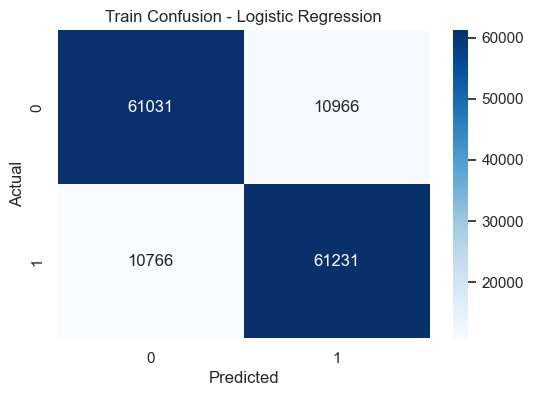

Train accuracy (Logistic Regression): 0.8491

Training: Naive Bayes


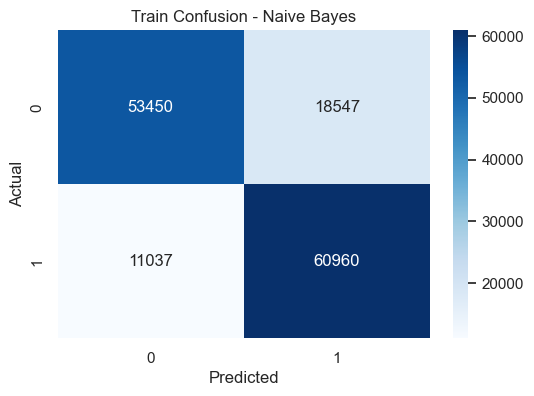

Train accuracy (Naive Bayes): 0.7945

Training: Decision Tree


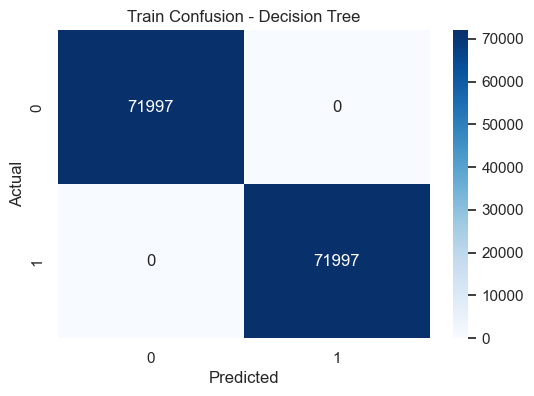

Train accuracy (Decision Tree): 1.0000

Training: Random Forest


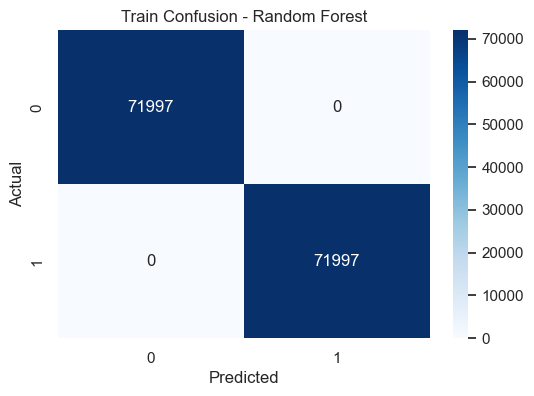

Train accuracy (Random Forest): 1.0000

Training: KNN


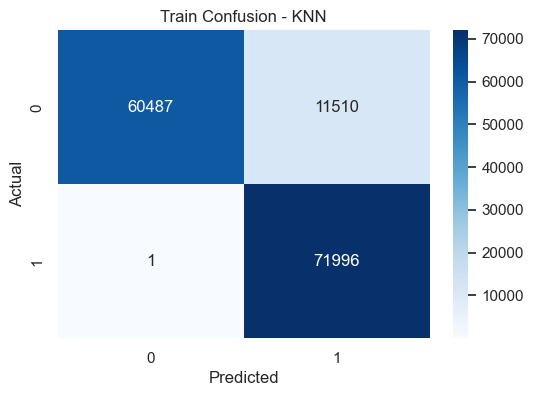

Train accuracy (KNN): 0.9201

Training: XGBoost


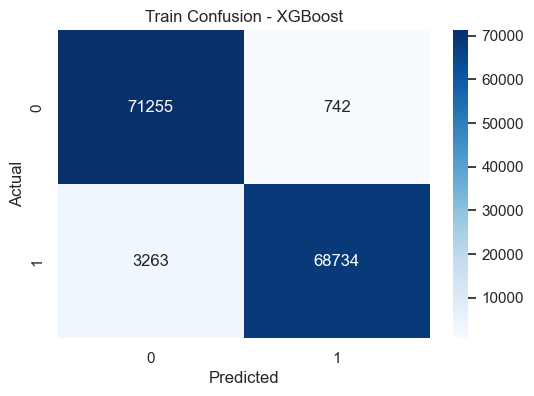

Train accuracy (XGBoost): 0.9722


,Model,Accuracy,Sensitivity,Precision,Specificity,F1,AUC
0,Logistic Regression,0.849077,0.850466,0.848110,0.847688,0.849286,0.928015
1,Naive Bayes,0.794547,0.846702,0.766725,0.742392,0.804731,0.846956
2,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,KNN,0.920059,0.999986,0.862166,0.840132,0.925976,0.999794
5,XGBoost,0.972186,0.954679,0.989320,0.989694,0.971691,0.995507


Saved microsoft_train_results.csv


In [74]:
trained_models = {}
train_results = []
for name, model in models.items():
    print("\nTraining:", name)
    model.fit(Xtr_sel, y_train_bal)
    trained_models[name] = model

    # Train predictions
    y_pred = model.predict(Xtr_sel)
    y_proba = model.predict_proba(Xtr_sel)[:,1] if hasattr(model, 'predict_proba') else None

    # Metrics
    acc_tr, sens_tr, prec_tr, spec_tr, f1_tr, auc_tr = get_metrics(y_train_bal, y_pred, y_proba)
    train_results.append([name, acc_tr, sens_tr, prec_tr, spec_tr, f1_tr, auc_tr])

    # Confusion matrix
    plot_confusion_matrix(y_train_bal, y_pred, f"Train Confusion - {name}")
    print(f"Train accuracy ({name}): {acc_tr:.4f}")

# ---------------------------------------------------------
# Create train_df OUTSIDE the loop
# ---------------------------------------------------------
train_df = pd.DataFrame(
    train_results,
    columns=["Model", "Accuracy", "Sensitivity", "Precision", "Specificity", "F1", "AUC"]
)

display(train_df)
train_df.to_csv("microsoft_train_results.csv", index=False)
print("Saved microsoft_train_results.csv")


# Test Models

In [80]:
test_results = []

for name, model in trained_models.items():
    y_pred_test = model.predict(Xte_sel)
    y_proba_test = model.predict_proba(Xte_sel)[:,1] if hasattr(model,'predict_proba') else None

    metrics = get_metrics(y_test, y_pred_test, y_proba_test)
    test_results.append([name] + list(metrics))

test_df = pd.DataFrame(test_results, columns=["Model","Acc","Sens","Prec","Spec","F1","AUC"])
# --- Fix inconsistent column names in test_df ---
test_df = test_df.rename(columns={
    "Acc": "Accuracy",
    "Sens": "Sensitivity",
    "Prec": "Precision",
    "Spec": "Specificity"
})

display(test_df) #test_df
test_df.to_csv("microsoft_test_results.csv", index=False)
print("Saved microsoft_test_results.csv")

,Model,Accuracy,Sensitivity,Precision,Specificity,F1,AUC
0,Logistic Regression,0.84585,0.819090,0.375917,0.848825,0.515328,0.914635
1,Naive Bayes,0.75210,0.793603,0.258927,0.747486,0.390460,0.837200
2,Decision Tree,0.86910,0.476262,0.377725,0.912773,0.421309,0.694517
3,Random Forest,0.92690,0.468266,0.701873,0.977888,0.561751,0.908519
4,KNN,0.77035,0.691154,0.258119,0.779154,0.375866,0.796840
5,XGBoost,0.93260,0.492754,0.747536,0.981499,0.593976,0.924619


Saved microsoft_test_results.csv


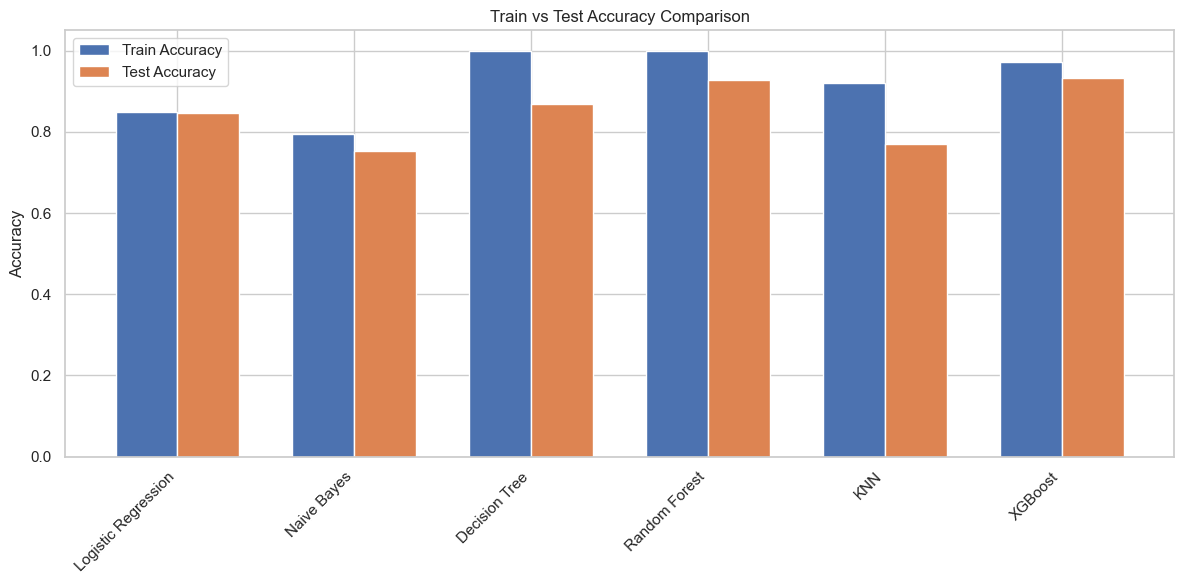

In [82]:
import os
combined = test_df.merge(train_df, on="Model", suffixes=("_Test","_Train"))

plt.figure(figsize=(12,6))

x = np.arange(len(combined))
width = 0.35

plt.bar(x - width/2, combined["Accuracy_Train"], width, label="Train Accuracy")
plt.bar(x + width/2, combined["Accuracy_Test"], width, label="Test Accuracy")

plt.xticks(x, combined["Model"], rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Comparison")
plt.legend()
plt.tight_layout()
plt.show()

    

In [84]:
best_model_name = test_df.sort_values("Accuracy",ascending=False).iloc[0]["Model"]
best_model = trained_models[best_model_name]

print("Best model:", best_model_name)

payload = {
    "encoder": encoder,
    "scaler": scaler,
    "selector": selector,
    "model": best_model,
    "label_encoder": le,
    "feature_names": list(X_final.columns)
}

joblib.dump(payload, "PurviModel_Microsoft.joblib")
print("Saved PurviModel_Microsoft.joblib")


Best model: XGBoost
Saved PurviModel_Microsoft.joblib
